In [29]:
#source: https://www.kaggle.com/maximknyazev/disaster-tweets-word2vec-tf-idf-81-acc/notebook#Let's-import-train-and-test-set

import pandas as pd

#import for plot
import matplotlib.pyplot as plt
import seaborn as sns

import spacy
import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from bs4 import BeautifulSoup
#!pip install contractions
import contractions


In [2]:
#load the data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
# get an idea about the data frame
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
id          3263 non-null int64
keyword     3237 non-null object
location    2158 non-null object
text        3263 non-null object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [5]:
#count total number of missing items for each colm
train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [6]:
test.isna().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

Text(0.5,1,'Real or not Disaster tweets')

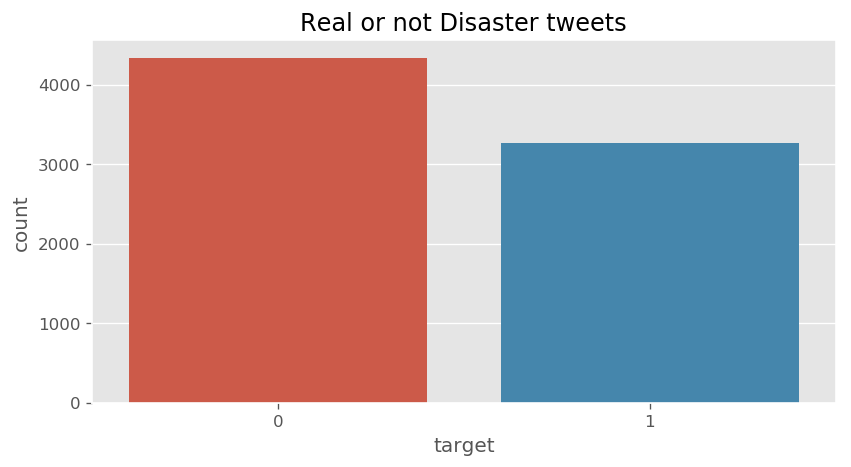

In [9]:
plt.style.use('ggplot')

plt.rcParams['figure.figsize'] = [8,4]
plt.rcParams['figure.dpi'] = 120
sns.countplot('target', data = train)
plt.title('Real or not Disaster tweets')

In [11]:
#helping functions to clean data

from spacy.lang.en.stop_words import STOP_WORDS as stopwords
global stopwords

def get_words_counts(tweets):
    length = len(str(tweets).split())
    return length

def get_chars_counts(tweets):
    string = tweets.split()
    x = ''.join(string)
    return len(x)

def get_average_word_length(tweets):
    count = get_chars_counts(tweets)/get_words_counts(tweets)
    return count

def get_stopwords_count(tweets):
        global stopwords
        stopwords = len([t for t in tweets.split() if t in stopwords])
        return stopwords
    
def get_hashtags_tags(tweets):
        hashtags = len([t for t in tweets.split() if t.startswith('#')])
        return hashtags
        
def get_email_tags(tweets):
        email = len([t for t in tweets.split() if t.startwith('@')])
        return email
    
def get_digit_counts(tweets):
        digits = re.findall(r'[0-9,.]+', tweets)
        return digits
    
def get_uppercase_units(tweets):
        uppercase = len([t for t in tweets.split() if t.isupper()])
        return uppercase
    
    
# With this function we can get some features for build a bit EDA

def get_features(df):
    if type(df) == pd.core.frame.DataFrame:
        df['words_counts'] = df['text'].apply(lambda x: get_words_counts(x))
        df['char_counts'] = df['text'].apply(lambda x: get_chars_counts(x))
        df['average_word_length'] = df['text'].apply(lambda x: get_average_word_length(x))
#        df['stopwords_counts'] = df['text'].apply(lambda x: get_stopwords_count(x))
        df['hashtags_counts'] = df['text'].apply(lambda x: get_hashtags_tags(x))
#        df['email_counts'] = df['text'].apply(lambda x: get_email_tags(x))
        df['digits_counts'] = df['text'].apply(lambda x: get_digit_counts(x))
        df['uppercase_counts'] = df['text'].apply(lambda x: get_uppercase_units(x))
        
    else:
        print('ERROR')
        
    return df

In [14]:
train = pd.DataFrame(train)
train = get_features(train)
train

,id,keyword,location,text,target,words_counts,char_counts,average_word_length,hashtags_counts,digits_counts,uppercase_counts
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,57,4.384615,1,[],1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7,32,4.571429,0,[.],0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22,112,5.090909,0,[.],0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,8,57,7.125000,1,"[13,000]",0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,16,72,4.500000,2,[],0
...,...,...,...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,11,73,6.636364,0,"[., 5]",0
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,20,106,5.300000,0,"[., .]",0
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,8,58,7.250000,0,"[1.94, 01, 04, 5, ., ., 8]",2
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,19,119,6.263158,0,"[., .]",0


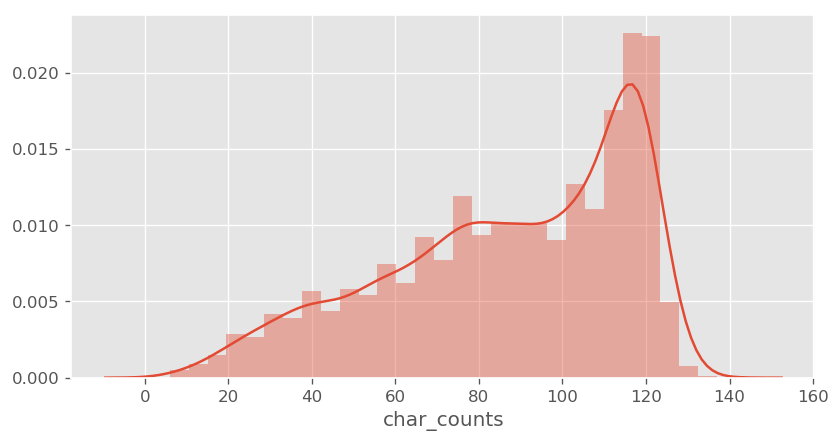

In [15]:
sns.distplot(train['char_counts']) 
sns.kdeplot(train[train['target'] == 1]['char_counts'], shade=True, color='red')
sns.kdeplot(train[train['target'] == 0]['char_counts'], shade=True, color= 'blue')

In [17]:
def remove_tweet_username(df):
    return re.sub('@[^\s]+','', df)

def make_lower(df):
    return df.lower()

def cont_exp(df):
    return contractions.fix(df)

def make_string(df):
    return str(df)

def remove_url(df):
    return re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '' , df)

def remove_email(df):
    return re.sub(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+)',"", df)

#Retweets
def remove_rt(df):
    df = str(df)
    return re.sub(r'\brt\b', "", df).strip()

def remove_html(df):
    return BeautifulSoup(df, 'lxml').get_text().strip()

def remove_dots(df):
    dot_pattern = re.compile(r'\.{1,}')
    single_dot = dot_pattern.sub(' ', df)
    return single_dot

def remove_special_chars(df):
    df = re.sub(r'[^\w]+', " ", df)
    df = ' '.join(df.split())
    return df

def make_base(df):
    df = str(df)
    x_list = []
    doc = nlp(df)

    for token in doc:
        lemma = token.lemma_
        if lemma == '-PRON-' or lemma == 'be':
            lemma = token.text

        x_list.append(lemma)
    return ' '.join(x_list)

def spelling_correction(df):
    df = TextBlob(df).correct()
    return df

def resub(df):
    return re.sub("(.)\\1{2,}", "\\1", df)



def get_clean_data(df):
    df = remove_url(df)
    df = remove_email(df)
    df = remove_html(df)
#    df = remove_dots(df)
#    df = make_base(df)
#    df = spelling_correction(df).raw_sentences[0]
    df = make_lower(df)
    df = make_string(df)
    df = cont_exp(df)
    df = remove_rt(df)
    df = resub(df)                             
    df = remove_tweet_username(df)
    
    return df


In [24]:
train['text'] = train['text'].apply(get_clean_data)
test['text'] = test['text'].apply(get_clean_data)

train['text'] = train['text'].apply(remove_special_chars)
test['text'] = test['text'].apply(remove_special_chars)

# trying to remove all digits from a columns
train['text'] = train['text'].str.replace('\d+', '')
test['text'] = test['text'].str.replace('\d+', '')

In [22]:
train['text'].head(20)

0     our deeds are the reason of this earthquake ma...
1                 forest fire near la ronge sask canada
2     all residents asked to shelter in place are be...
3     13 0 people receive wildfires evacuation order...
4     just got sent this photo from ruby alaska as s...
5     rockyfire update california hwy 20 closed in b...
6     flood disaster heavy rain causes flash floodin...
7     i am on top of the hill and i can see a fire i...
8     there is an emergency evacuation happening now...
9     i am afraid that the tornado is coming to our ...
10          three people died from the heat wave so far
11    haha south tampa is getting flooded hah wait a...
12    raining flooding florida tampabay tampa 18 or ...
13                flood in bago myanmar we arrived bago
14    damage to school bus on 80 in multi car crash ...
15                                       what is up man
16                                        i love fruits
17                                     summer is

In [27]:
# Use Gensim

#!pip install gensim
from gensim.parsing.preprocessing import remove_stopwords

train['text'] = train['text'].apply(remove_stopwords)
test['text'] = test['text'].apply(remove_stopwords)

In [33]:
text = train['text']
y = train['target']

tfidf = TfidfVectorizer()
X = tfidf.fit_transform(text)

X.shape

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 7, stratify=y)

In [34]:
# Support Vector Machines
from sklearn.svm import LinearSVC

clf_svm = LinearSVC()

def run_SVM(clf_svm, X_train, X_test, y_train, y_test):
    clf_svm.fit(X_train, y_train)
    y_pred = clf_svm.predict(X_test)
    
    print()
    print('Classification Report:')
    print(classification_report(y_test, y_pred))
    
run_SVM(clf_svm, X_train, X_test, y_train, y_test)



Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.87      0.82      1086
           1       0.79      0.68      0.73       818

    accuracy                           0.79      1904
   macro avg       0.79      0.77      0.78      1904
weighted avg       0.79      0.79      0.78      1904



In [35]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression()

def run_LR(clf_lr, X_train, X_test, y_train, y_test):
    clf_lr.fit(X_train, y_train)
    y_pred = clf_lr.predict(X_test)
    
    print()
    print('Classification Report:')
    print(classification_report(y_test, y_pred))
    
run_LR(clf_lr, X_train, X_test, y_train, y_test)


Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.92      0.83      1086
           1       0.86      0.61      0.71       818

    accuracy                           0.79      1904
   macro avg       0.81      0.77      0.77      1904
weighted avg       0.80      0.79      0.78      1904



/Users/isa14/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [36]:
#K Nearest Neighbours

from sklearn.neighbors import KNeighborsClassifier

clf_knn = KNeighborsClassifier()

def run_knn(clf_knn, X_train, X_test, y_train, y_test):
    clf_knn.fit(X_train, y_train)
    y_pred = clf_knn.predict(X_test)
    
    print()
    print('Classification Report:')
    print(classification_report(y_test, y_pred))
    
run_knn(clf_knn, X_train, X_test, y_train, y_test)


Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.98      0.78      1086
           1       0.92      0.27      0.42       818

    accuracy                           0.68      1904
   macro avg       0.78      0.63      0.60      1904
weighted avg       0.76      0.68      0.62      1904



In [37]:
# Multinominal Naive Bayes

from sklearn.naive_bayes import MultinomialNB

clf_mnb = MultinomialNB()

def run_mnb(clf_mnb, X_train, X_test, y_train, y_test):
    clf_mnb.fit(X_train, y_train)
    y_pred = clf_mnb.predict(X_test)
    
    print()
    print('Classification Report:')
    print(classification_report(y_test, y_pred))
    
run_mnb(clf_mnb, X_train, X_test, y_train, y_test)


Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.89      0.83      1086
           1       0.82      0.66      0.73       818

    accuracy                           0.79      1904
   macro avg       0.80      0.77      0.78      1904
weighted avg       0.79      0.79      0.79      1904



In [38]:
# Decision Tree

from sklearn.tree import DecisionTreeClassifier

clf_tree = DecisionTreeClassifier()

def run_tree(clf_tree, X_train, X_test, y_train, y_test):
    clf_tree.fit(X_train, y_train)
    y_pred = clf_tree.predict(X_test)
    
    print()
    print('Classification Reprot:')
    print(classification_report(y_test, y_pred))

run_tree(clf_tree, X_train, X_test, y_train, y_test)




Classification Reprot:
              precision    recall  f1-score   support

           0       0.76      0.77      0.77      1086
           1       0.69      0.68      0.69       818

    accuracy                           0.73      1904
   macro avg       0.73      0.73      0.73      1904
weighted avg       0.73      0.73      0.73      1904



In [40]:
#Random Forest CLassifier

from sklearn.ensemble import RandomForestClassifier

clf_forest = RandomForestClassifier()

def run_forest(clf_forest, X_train, X_test, y_train, y_test):
    clf_forest.fit(X_train, y_train)
    y_pred = clf_forest.predict(X_test) 
    
    print()
    print("Classificiation Report:")
    print(classification_report(y_test, y_pred))
    
run_forest(clf_forest, X_train, X_test, y_train, y_test)

/Users/isa14/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)



Classificiation Report:
              precision    recall  f1-score   support

           0       0.74      0.89      0.81      1086
           1       0.80      0.59      0.68       818

    accuracy                           0.76      1904
   macro avg       0.77      0.74      0.74      1904
weighted avg       0.77      0.76      0.75      1904



0.7584033613445378

In [43]:
#Summary of Results 

models_default_tfidf = {'Support Vector Machines': clf_svm.score(X_test, y_test),
          'Logistic Regression': clf_lr.score(X_test, y_test),
          'KNearest Neightbors': clf_knn.score(X_test, y_test),
          'Multinominal Naive Bayes': clf_mnb.score(X_test, y_test),
          'Decision Tree': clf_tree.score(X_test, y_test),
          'Random Forest Classifier': clf_forest.score(X_test, y_test)}


models_default_tfidf

{'Support Vector Machines': 0.7857142857142857,
 'Logistic Regression': 0.789390756302521,
 'KNearest Neightbors': 0.6811974789915967,
 'Multinominal Naive Bayes': 0.7904411764705882,
 'Decision Tree': 0.7337184873949579,
 'Random Forest Classifier': 0.7584033613445378}

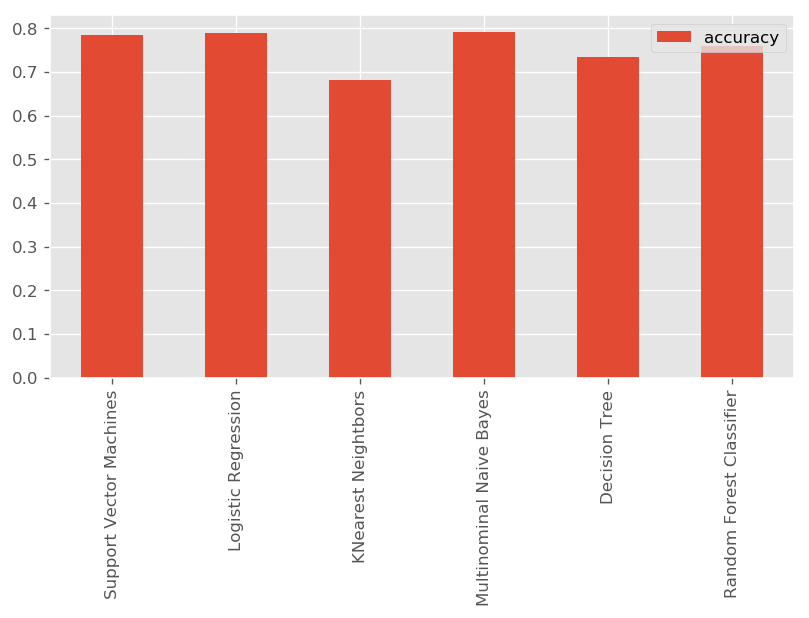

In [44]:
default_models_compare = pd.DataFrame(models_default_tfidf, index=['accuracy'])
default_models_compare.T.plot.bar()

In [50]:
#!python -m spacy download en_core_web_lg
import en_core_web_lg
nlp = en_core_web_lg.load()

def get_vec(x):
    doc = nlp(x)
    vec = doc.vector
    return vec

train['vectors'] = train['text'].apply(lambda x: get_vec(x))
train.head()

,id,keyword,location,text,target,words_counts,char_counts,average_word_length,hashtags_counts,digits_counts,uppercase_counts,vectors
0,1,NaN,NaN,deeds reason earthquake allah forgive,1,13,57,4.384615,1,[],1,"[-0.577874, -0.020427203, -0.153596, -0.104262..."
1,4,NaN,NaN,forest near la ronge sask canada,1,7,32,4.571429,0,[.],0,"[0.0059129945, -0.12560566, -0.195046, -0.3924..."
2,5,NaN,NaN,residents asked shelter place notified officer...,1,22,112,5.090909,0,[.],0,"[0.07983147, 0.06994864, -0.0071826326, -0.000..."
3,6,NaN,NaN,people receive wildfires evacuation orders cal...,1,8,57,7.125000,1,"[13,000]",0,"[-0.22658165, 0.19888365, -0.027298167, -0.249..."
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1,16,72,4.500000,2,[],0,"[-0.15872057, -0.08627854, 0.112908565, -0.068..."


In [63]:
import numpy as np
#why did we do the following? 
X = train['vectors'].to_numpy()

#X.shape #(7613,)

X = X.reshape(-1, 1) #https://stackoverflow.com/questions/57962718/reshaping-data-in-numpy-with-1-1-what-does-it-mean

X.shape #(7613, 1)

X = np.concatenate(np.concatenate(X, axis = 0), axis = 0).reshape(-1, 300) #????? why?

X.shape

array([[-0.577874  , -0.0204272 , -0.153596  , ...,  0.322171  ,
        -0.04134401, -0.20528519],
       [ 0.00591299, -0.12560566, -0.195046  , ..., -0.13940184,
        -0.26227203,  0.13546816],
       [ 0.07983147,  0.06994864, -0.00718263, ...,  0.12075873,
         0.10999563, -0.07356182],
       ...,
       [ 0.07628781,  0.15273039,  0.100564  , ...,  0.12497199,
         0.079596  ,  0.0477878 ],
       [ 0.00729172,  0.0888634 , -0.28466085, ..., -0.06633175,
         0.03403912,  0.10538907],
       [-0.08109076,  0.261985  ,  0.07463737, ..., -0.3299342 ,
        -0.14810582,  0.17813051]], dtype=float32)

In [53]:
### Normalization

from sklearn.preprocessing import normalize

X = normalize(X)
X

array([[-0.13712625, -0.00484726, -0.03644747, ...,  0.07644937,
        -0.0098107 , -0.04871302],
       [ 0.00153096, -0.03252115, -0.05050027, ..., -0.03609318,
        -0.06790607,  0.03507469],
       [ 0.02037159,  0.01784967, -0.00183288, ...,  0.03081551,
         0.02806895, -0.01877168],
       ...,
       [ 0.01926466,  0.03856841,  0.02539504, ...,  0.03155869,
         0.02010007,  0.01206767],
       [ 0.00204144,  0.02487876, -0.07969546, ..., -0.01857066,
         0.00952981,  0.02950539],
       [-0.02173158,  0.07020958,  0.02000213, ..., -0.08841935,
        -0.039691  ,  0.04773735]], dtype=float32)

In [54]:
y = train['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 7, stratify=y)

In [55]:
def word2vec_models(clf, X_train, X_test, y_train, y_test):
    print('SVM MODEL:')
    run_SVM(clf_svm, X_train, X_test, y_train, y_test)
    print('LOGISTIC REGRESSION MODEL:')
    run_LR(clf_lr, X_train, X_test, y_train, y_test)
    print('KNEAREST NEIGHBORS MODEL:')
    run_knn(clf_knn, X_train, X_test, y_train, y_test)
    #run_mnb(clf_mnb, X_train, X_test, y_train, y_test)
    print('DECISION TREE MODEL:')
    run_tree(clf_tree, X_train, X_test, y_train, y_test)
    print('RANDOM FOREST MODEL:')
    run_forest(clf_forest, X_train, X_test, y_train, y_test)
    
    return word2vec_models

In [56]:
clf_list = [run_SVM, run_LR, run_knn, run_mnb, run_tree, run_forest]

word2vec_models(clf_list, X_train, X_test, y_train, y_test)

SVM MODEL:

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.87      0.83      1086
           1       0.80      0.72      0.76       818

    accuracy                           0.80      1904
   macro avg       0.80      0.79      0.80      1904
weighted avg       0.80      0.80      0.80      1904

LOGISTIC REGRESSION MODEL:


/Users/isa14/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.87      0.84      1086
           1       0.80      0.72      0.76       818

    accuracy                           0.81      1904
   macro avg       0.81      0.80      0.80      1904
weighted avg       0.81      0.81      0.80      1904

KNEAREST NEIGHBORS MODEL:

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.81      0.81      1086
           1       0.75      0.74      0.75       818

    accuracy                           0.78      1904
   macro avg       0.78      0.78      0.78      1904
weighted avg       0.78      0.78      0.78      1904

DECISION TREE MODEL:

Classification Reprot:
              precision    recall  f1-score   support

           0       0.74      0.76      0.75      1086
           1       0.67      0.65      0.66       818

    accuracy                           0.71      1904
   macro 

<function __main__.word2vec_models(clf, X_train, X_test, y_train, y_test)>

In [57]:
models_default_word2vec = {'Support Vector Machines': clf_svm.score(X_test, y_test),
          'Logistic Regression': clf_lr.score(X_test, y_test),
          'KNearest Neightbors': clf_knn.score(X_test, y_test),
          'Decision Tree': clf_tree.score(X_test, y_test),
          'Random Forest Classifier': clf_forest.score(X_test, y_test)}

models_default_word2vec

{'Support Vector Machines': 0.8040966386554622,
 'Logistic Regression': 0.8061974789915967,
 'KNearest Neightbors': 0.7841386554621849,
 'Decision Tree': 0.7137605042016807,
 'Random Forest Classifier': 0.7447478991596639}